### Notebook Goal

To create a machine learning model that recognizes hate speech messages to automatically detect and remove these messages from YouTube comments. This will reduce the workload of moderators and help create a safer environment for users.

### Importing Libraries and Dataset

In [1]:
!pip install wordcloud==1.9.2 -q
!pip install emoji==2.8.0 -q
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
!pip install xgboost -q


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
pip install lightgbm -q


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install catboost -q


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
!pip install nlpaug -q


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import string
import emoji
from nlpaug.util import Action
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stopword=set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer

#Models

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset definition

In [7]:
df=pd.read_csv('youtoxic_english_1000.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   CommentId        1000 non-null   object
 1   VideoId          1000 non-null   object
 2   Text             1000 non-null   object
 3   IsToxic          1000 non-null   bool  
 4   IsAbusive        1000 non-null   bool  
 5   IsThreat         1000 non-null   bool  
 6   IsProvocative    1000 non-null   bool  
 7   IsObscene        1000 non-null   bool  
 8   IsHatespeech     1000 non-null   bool  
 9   IsRacist         1000 non-null   bool  
 10  IsNationalist    1000 non-null   bool  
 11  IsSexist         1000 non-null   bool  
 12  IsHomophobic     1000 non-null   bool  
 13  IsReligiousHate  1000 non-null   bool  
 14  IsRadicalism     1000 non-null   bool  
dtypes: bool(12), object(3)
memory usage: 35.3+ KB


In [8]:
# Summary statistics for numerical features
df.describe()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,13,997,2,2,2,2,2,2,2,2,2,1,2,1
top,UgiWKCAoJJjRsXgCoAEC,9pr1oE34bIM,run them over,False,False,False,False,False,False,False,False,False,False,False,False
freq,1,274,3,538,647,979,839,900,862,875,992,999,1000,988,1000


In [9]:
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


### Fields descriptions

• CommentId: Unique identifier for each comment in the dataset.
• VideoId: Unique identifier for each video to which the comment belongs.
• Text: Contains the text of the comment in question.
• IsToxic: Boolean feature indicating whether the comment is considered toxic or not. A True value means that the comment is classified as toxic.
• IsAbusive: Similar to "IsToxic", this feature is boolean and indicates whether the comment is considered abusive.
• IsThreat: Indicates whether the comment contains threats. It is a boolean feature.
• IsProvocative: Indicates whether the comment is provocative. It is a boolean feature.
• IsObscene: Indicates whether the comment contains obscene content. It is a boolean feature.
• IsHatespeech: This boolean feature indicates whether the comment is hate speech.
• IsRacist: Indicates whether the comment contains racist content. It is a boolean feature.
• IsNationalist: Indicates whether the comment is nationalist. It is a boolean feature.
• IsSexist: Indicates whether the comment contains sexist content. It is a boolean feature.
• IsHomophobic: This boolean feature indicates whether the comment contains homophobic content.
• IsReligiousHate: Indicates whether the comment contains religious hate. It is a boolean feature.
• IsRadicalism: Indicates whether the comment is related to radicalism. It is a boolean feature.

### Duplicate Data Check

In [10]:
df.duplicated().sum()

0

### Missing Values Check

In [11]:
df.isnull().sum()

CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64

In [12]:
data = [] # Crear una lista de diccionarios para almacenar los nombres de las columnas y sus valores únicos

for column in df.columns:
    n_values = df[column].nunique()  # Obtener el número de valores únicos
    data.append({'columnas': column, 'n_values': n_values})

# Crear un DataFrame a partir de la lista de diccionarios
unique_values_df = pd.DataFrame(data)

unique_values_df

,columnas,n_values
0,CommentId,1000
1,VideoId,13
2,Text,997
3,IsToxic,2
4,IsAbusive,2
5,IsThreat,2
6,IsProvocative,2
7,IsObscene,2
8,IsHatespeech,2
9,IsRacist,2


In [13]:
columns = df.select_dtypes(include = ['object', 'boolean'])
list_columns = list(columns)

for col in list_columns:
    print(f'Column name: {col}')
    print(df[col].value_counts())
    print()

Column name: CommentId
UgiWKCAoJJjRsXgCoAEC          1
Ughs3w350i3DvXgCoAEC          1
Ugj96ojKH5Ui7XgCoAEC          1
Ugycw-ryczBL4ZmdRUh4AaABAg    1
UggxCL2J1VOhLHgCoAEC          1
                             ..
UgiLoDtsZBccZXgCoAEC          1
Ugz7lS0OMX9VAL_UXp94AaABAg    1
UgjwWrcF5iU6s3gCoAEC          1
UghAbXMwBZQ043gCoAEC          1
UggGaHoBXiLwX3gCoAEC          1
Name: CommentId, Length: 1000, dtype: int64

Column name: VideoId
9pr1oE34bIM    274
04kJtp6pVXI    172
cT14IbTDW2c    146
dG7mZQvaQDk    112
TZxEyoplYbI    104
bUgKZMSxr3E     39
8HB18hZrhXc     38
4rCweDxDqdw     37
Dt9-byUhPdg     34
#NAME?          16
dDbRyFIkNII     10
XRuCW80L9mA     10
5vF4si3hoRA      8
Name: VideoId, dtype: int64

Column name: Text
run them over                                                                                                                                                                                                                                                            

### Conclusion
This dataset appears to be clean with no evident missing values or duplicates. The boolean columns serve as labels indicating the presence of toxic or hateful content in the comments. This provides a robust foundation for developing a machine learning model capable of automatically detecting hate messages and assisting in content moderation on YouTube ultimately fostering a safer environment for users.

## Visual Representation of Proportion of '1' Values Across Columns

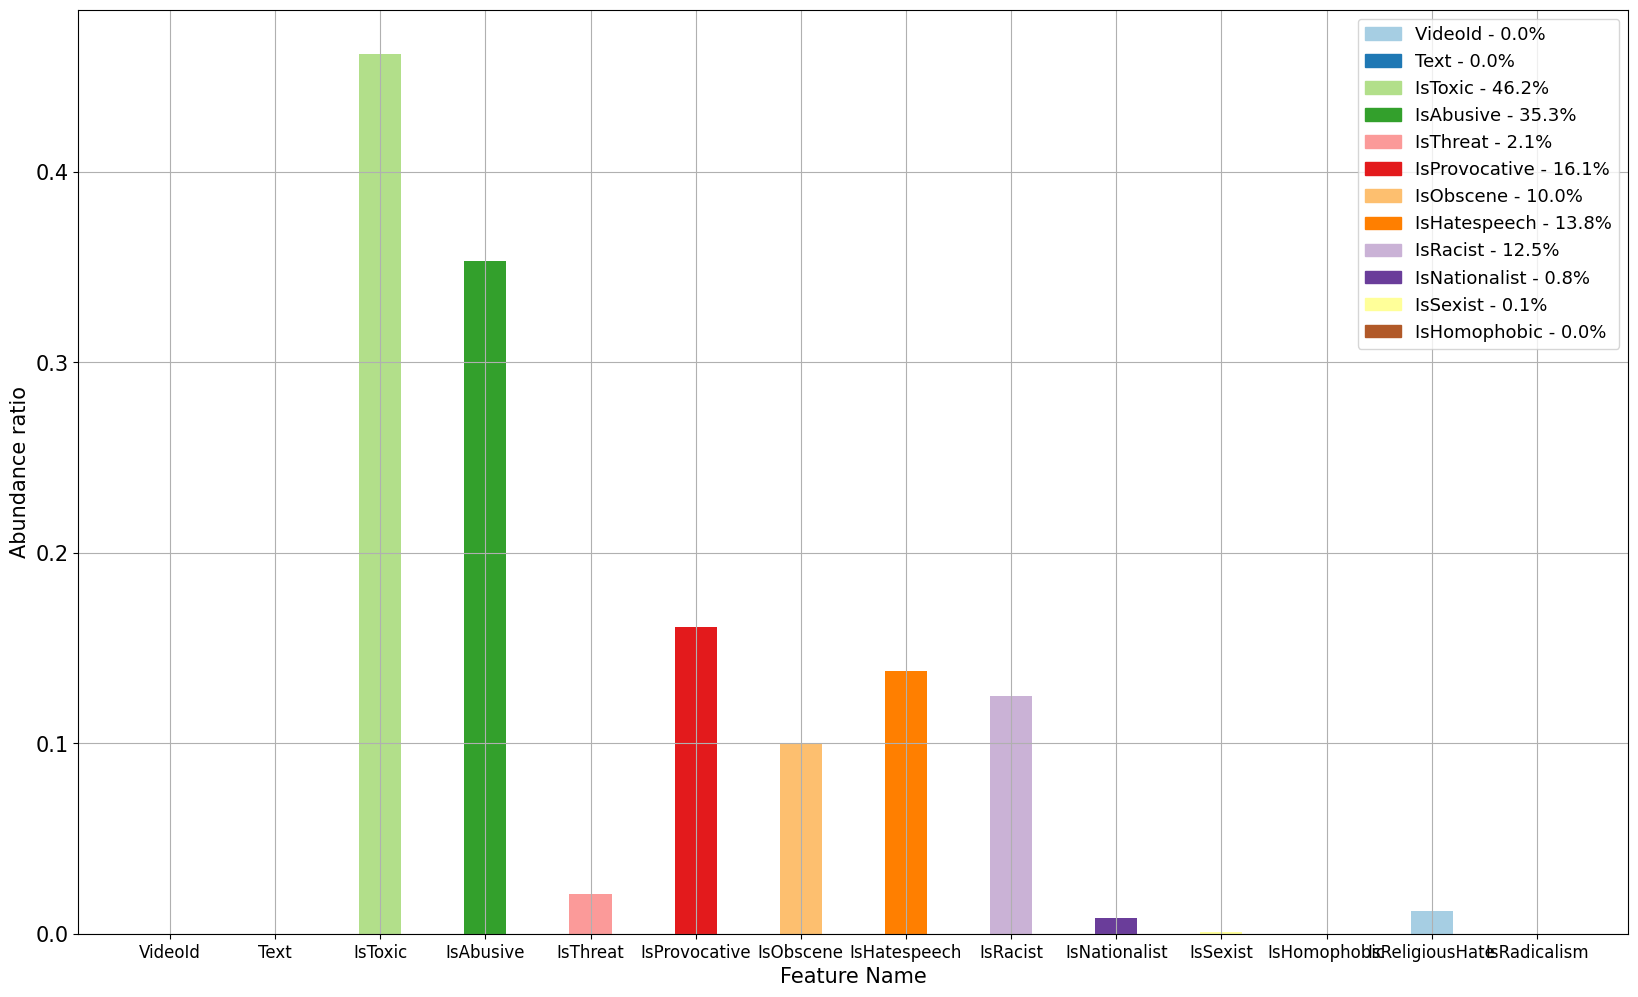

In [14]:
columns_names = df.columns.tolist()
bar_df = {}
for name in columns_names[1:]:
    bar_df[name] = len(df.loc[df[name] == 1]) / len(df[name])
    
    
bar_name = list(bar_df.keys())
values = list(bar_df.values())
fig = plt.figure(figsize = (20, 12))
colors = plt.cm.Paired(np.arange(12))

plt.bar(bar_name, values, color = colors,
        width = 0.4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.xlabel("Feature Name", fontsize=15)
plt.ylabel("Abundance ratio", fontsize=15)
#plt.title("Percentage of each feature from all comments", fontsize=30)

patch = [mpatches.Patch(color=color, label=f"{bar_name} - {value*100}%") 
         for color,value, bar_name in zip(colors, values, bar_name)]
plt.legend(handles=patch, fontsize=13)
plt.grid()
plt.show()

## Analysis of Boolean Column Distributions

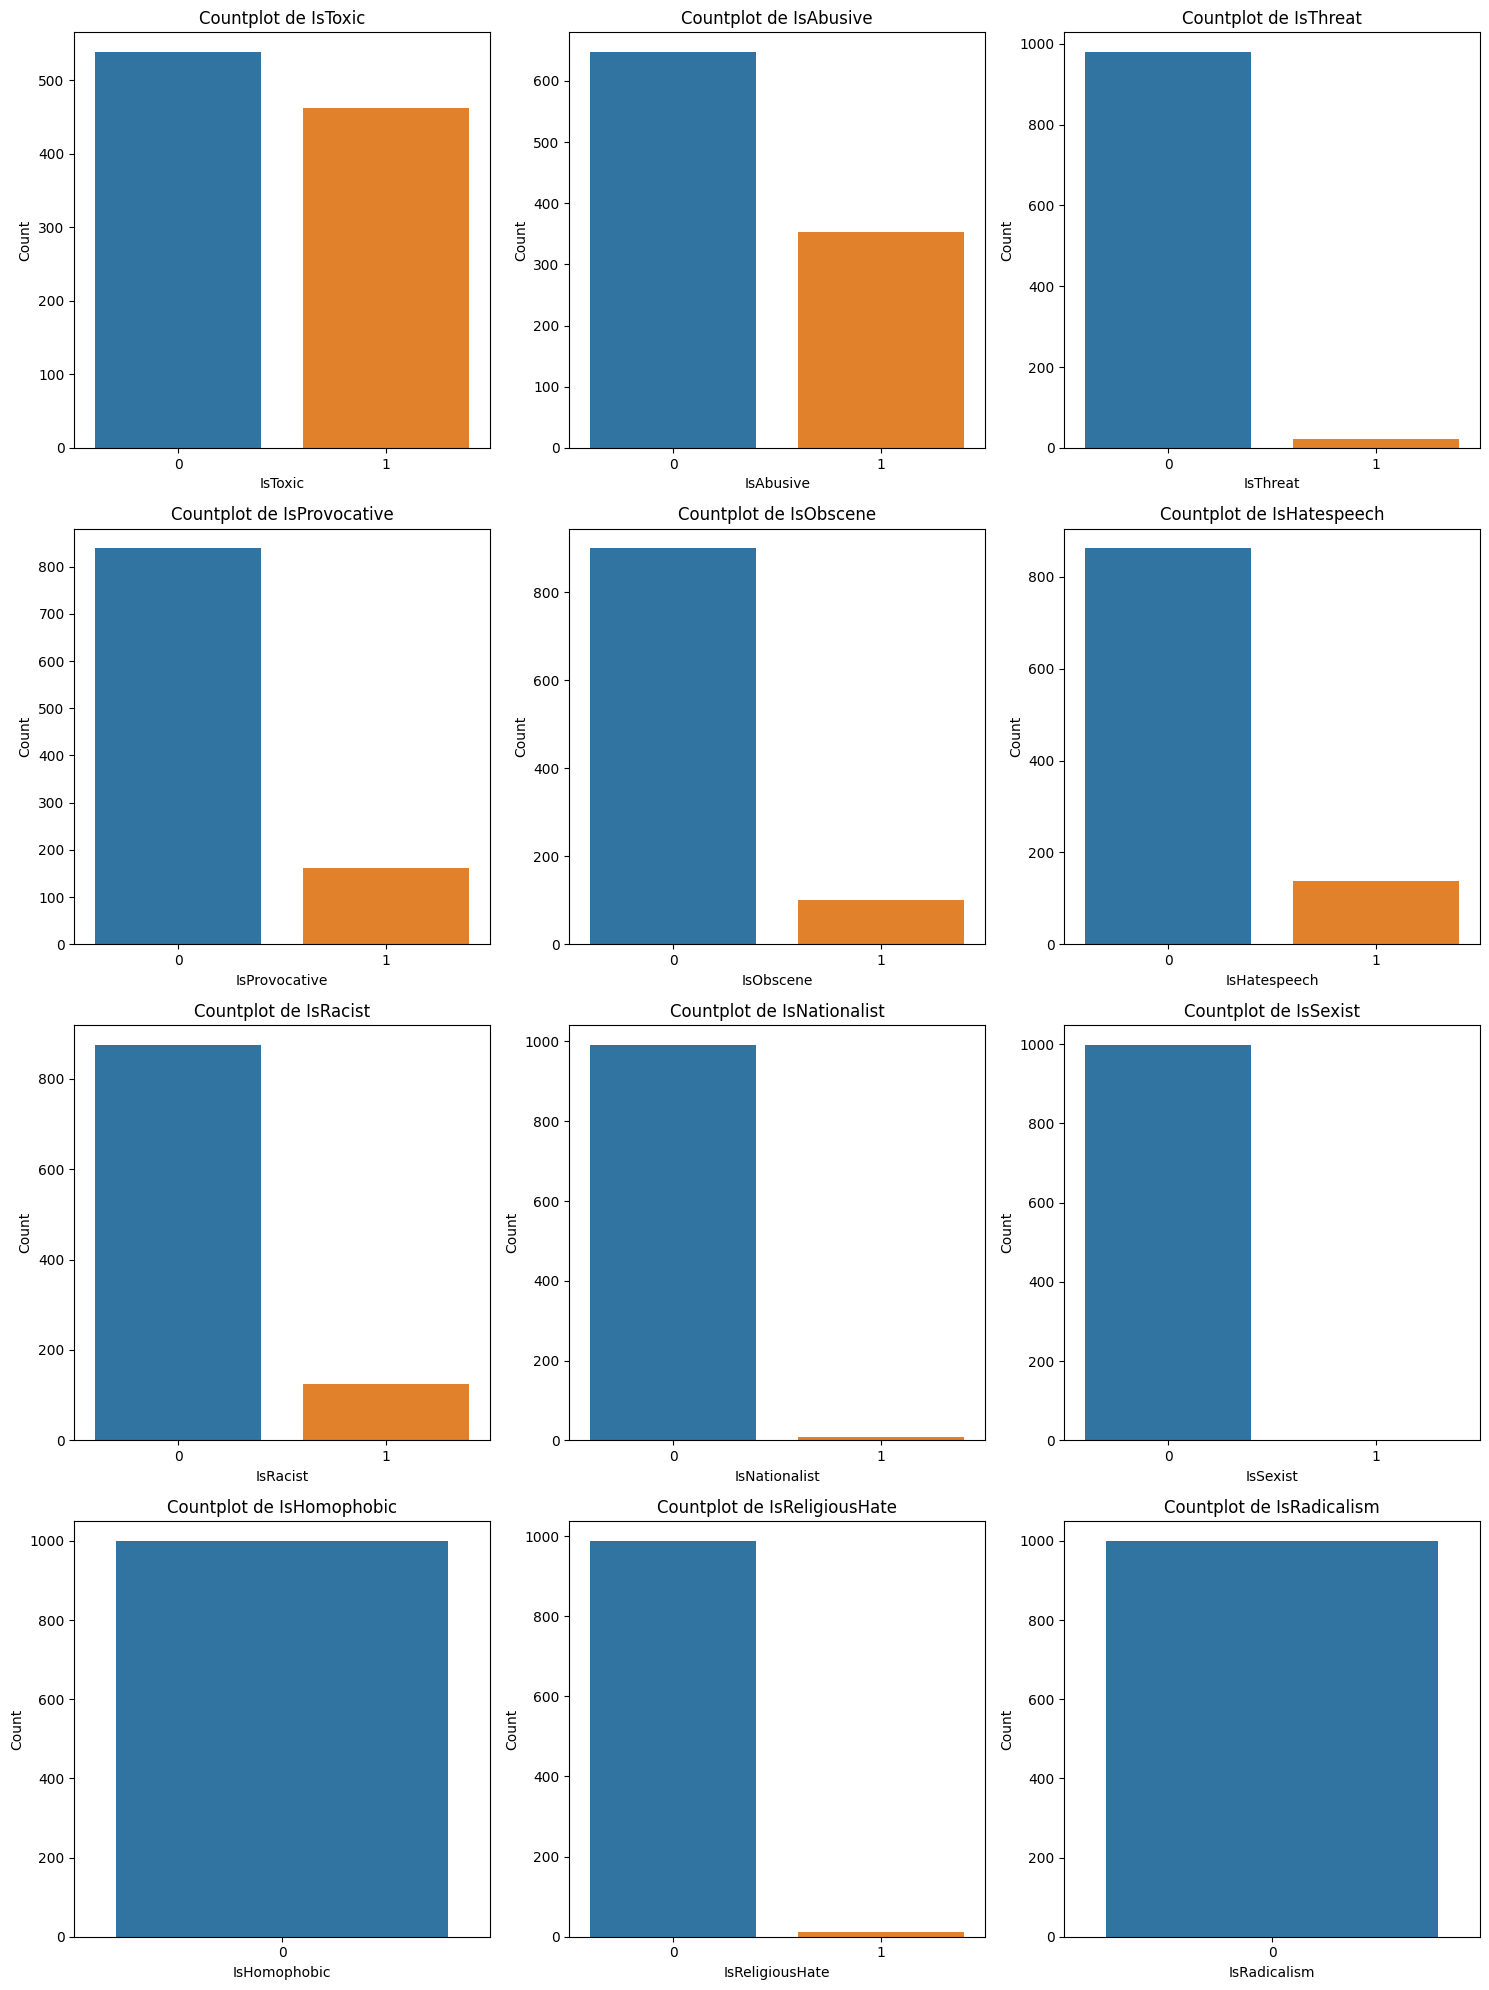

In [15]:
boolean_columns = [column for column in df.columns if df[column].dtype == bool]

num_plots = len(boolean_columns)
num_cols = 3  
num_rows = -(-num_plots // num_cols)  

plt.figure(figsize=(15, 5 * num_rows))

for i, column in enumerate(boolean_columns):
    df[column] = df[column].map({True: 1, False: 0})

    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(data=df, x=column)
    plt.title(f'Countplot de {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Summary of Column Analysis

- Columns like "IsToxic"  and "IsAbusive" display a more balanced distribution between True and False, which could be beneficial for training a model as there is a considerable number of samples for both classes.

- Some columns exhibit a significant imbalance between True and False, for example, "IsHomophobic" and "IsRadicalism". This could potentially bias the model towards the majority class and impact its ability to predict the minority class accurately.

- Columns like "IsThreat", "IsNationalist", "IsSexist" and "IsReligiousHate",  predominantly consist of a single class, which might not be useful for model training due to the lack of sufficient samples for the other class. 

Imbalanced columns may introduce biases into the model. It is essential to consider whether the imbalance accurately represents the class distribution in the data or if it is due to how the data was collected.

## The correlation matrix

In [16]:
# Distribution of tags in each category
toxic_labels = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

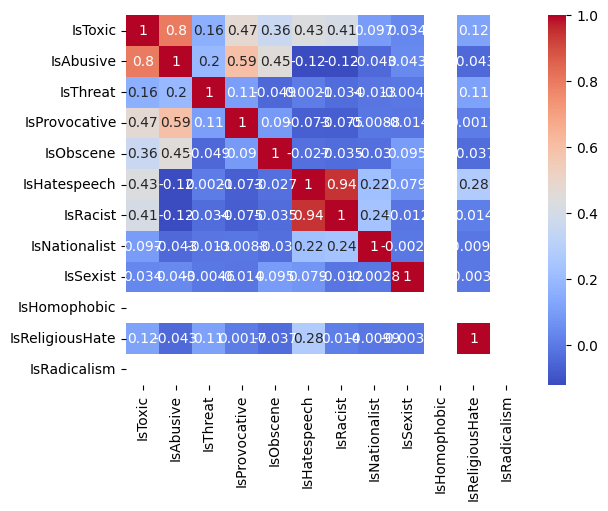

In [17]:
correlation_matrix = df[toxic_labels].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [18]:
corr_matrix = df.corr()
corr_matrix["IsToxic"].sort_values(ascending = False)

IsToxic            1.000000
IsAbusive          0.797086
IsProvocative      0.472718
IsHatespeech       0.431774
IsRacist           0.407869
IsObscene          0.359707
IsThreat           0.158048
IsReligiousHate    0.118928
IsNationalist      0.096908
IsSexist           0.034142
IsHomophobic            NaN
IsRadicalism            NaN
Name: IsToxic, dtype: float64

The correlation analysis suggests that columns like "IsAbusive", "IsProvocative", "IsHatespeech", "IsRacist" and "IsObscene" could be **more influential or related** to the presence of toxicity, while "IsHomophobic" and "IsRadicalism" **seem to have no linear correlation** with "IsToxic".

## Visualization of Toxic and Non-Toxic Text Distribution

In [19]:
# split all text by toxic parameter
non_toxic_mark = df.IsToxic.loc[df.IsToxic==0]
toxic_mark = df.IsToxic.loc[df.IsToxic==1]

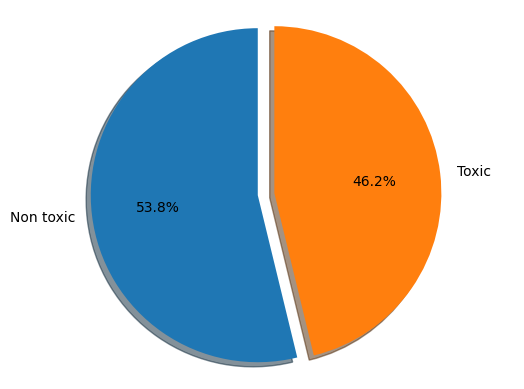

In [20]:
labels = "Non toxic", "Toxic"
sizes = [non_toxic_mark.count(), 
         toxic_mark.count()]
explode = (0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%",
        shadow=True, startangle=90)
ax1.axis("equal") 
plt.show()

The dataset exhibits a relatively balanced distribution with 53.8% of comments labeled as non-toxic and 46.2% as toxic. This balanced ratio between toxic and non-toxic comments is crucial for modeling, enabling the consideration of both categories effectively in the training process. The proportionate representation of both types of comments suggests the significance of a comprehensive analysis, potentially influencing the model's training and evaluation, ensuring a more robust performance and generalization for the classification task.

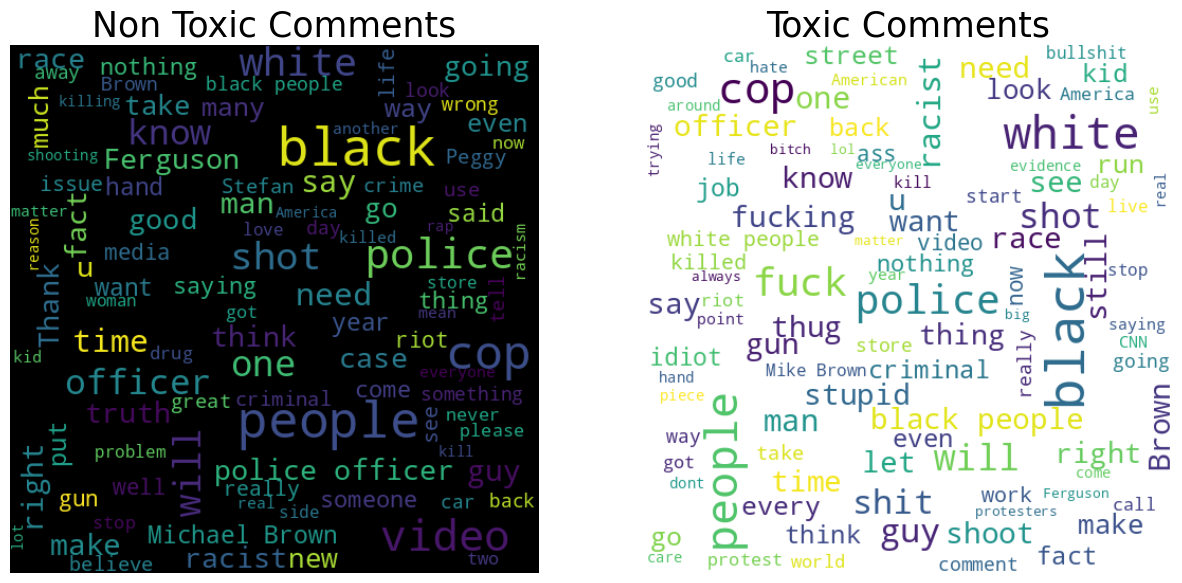

In [21]:
# Create a chain of more frequent Non-toxic comments in dataframe

untoxic_comments = df.Text.loc[df.IsToxic==0]
new_untoxic_commentss = untoxic_comments.value_counts().to_frame().head(1000)
full_untoxic_commentss = "".join(new_untoxic_commentss.index.tolist())

# Create a chain of more frequent toxic comments in dataframe

toxic_comments = df.Text.loc[df.IsToxic==1]
new_toxic_commentss = toxic_comments.value_counts().to_frame().head(1000)
full_toxic_commentss = "".join(new_toxic_commentss.index.tolist())

# Generate a visual image of the most frequent words in a set of non-toxic and toxic comments

wordcloud_untoxic = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="black") \
    .generate(full_untoxic_commentss)

wordcloud_toxic = WordCloud(max_font_size=50, max_words=100,width=500, height=500,
                      background_color="white") \
    .generate(full_toxic_commentss) 

# Data visualization

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(wordcloud_untoxic, interpolation="bilinear")
ax1.axis("off")
ax2.imshow(wordcloud_toxic, interpolation="bilinear")
ax2.axis("off")
ax1.set_title("Non Toxic Comments", fontsize=25)
ax2.set_title("Toxic Comments", fontsize=25)
plt.show()   

## Cleaning and initial text processing

In [22]:
# Create the list of stopwords
stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # If the text is a list, join it into a single string
    if isinstance(text, list):
        text = ' '.join(text)

    # Convert text to lowercase
    text = str(text).lower()

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stopwords
    text = text.split()
    text = [word for word in text if word not in stopword]

    # Lemmatize
    text = [lemmatizer.lemmatize(word) for word in text]

    # Tokenize the text
    tokens = [token.lower() for token in word_tokenize(' '.join(text))]

    # Join the tokens into a single string
    text = ' '.join(tokens)

    return text

In [23]:
# Examples before and after preprocessing

for idx in range(5):  
    original_text = df["Text"].iloc[idx]
    preprocessed_text = preprocess_text(original_text)
    print(f"Original: {original_text}")
    print(f"Preprocesado: {preprocessed_text}\n")

Original: If only people would just take a step back and not make this case about them, because it wasn't about anyone except the two people in that situation.  To lump yourself into this mess and take matters into your own hands makes these kinds of protests selfish and without rational thought and investigation.  The guy in this video is heavily emotional and hyped up and wants to be heard, and when he gets heard he just presses more and more.  He was never out to have a reasonable discussion.  Kudos to the Smerconish for keeping level the whole time and letting Masri make himself out to be a fool.  How dare he and those that tore that city down in protest make this about themselves and to dishonor the entire incident with their own hate.  By the way, since when did police brutality become an epidemic?  I wish everyone would just stop pretending like they were there and they knew EXACTLY what was going on, because there's no measurable amount of people that honestly witnessed this in

We decided based on the previous study carried out, to temporarily dispense with all the columns except "Text" and "IsToxic" (column to predict), to perform the following tests and check how the model fares with that decision.

## New Dataset

In [24]:
# Copy Dataframe

data_clean = df.copy()

In [25]:
# Create new dataset with only 'Text' and 'IsToxic' columns

data_clean = data_clean[["Text", "IsToxic"]]

In [26]:
# Preprocess the text

data_clean["Text"] = data_clean["Text"].apply(preprocess_text)

## 
Split data into training and test sets

In [27]:
X = data_clean['Text']
y = data_clean.drop(['Text'], axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
print("X_train:")
print(X_train)
print()

print("y_train:")
print(y_train)
print()

print("X_test:")
print(X_test)
print()

print("y_test:")
print(y_test)

X_train:
29     blood street worried word getting tired way ma...
535    really care much cop somebody tell dumb as gir...
695    dumb fuck screwing fellow citizen instead prot...
557    non lethal weapon control crowd lol love rogan...
836    yea beat white people rob black owned store ca...
                             ...                        
106    think indecent unessacerry event one person sh...
270    clearly racist shrill canadian vegatable plant...
860    people see herei cant even understand sayingis...
435                 far base cant even call propaganda b
102    dont want son death vain let burn bitch stupid...
Name: Text, Length: 800, dtype: object

y_train:
     IsToxic
29         0
535        1
695        1
557        1
836        1
..       ...
106        0
270        1
860        1
435        1
102        1

[800 rows x 1 columns]

X_test:
521    call anarchist defend cop shooting unarmed civ...
737                    mother told thing god bless woman
740    love 

## Data Augmentation

We intend to employ the data augmentation technique, specifically 'synonym replacement,' to generate subtle variations in the original training data. This approach can be advantageous by introducing greater diversity to the dataset, enabling the model to learn and generalize more effectively from a broader set of examples.

In [30]:
# Configure the synonym augmenter
aug = naw.SynonymAug(aug_src='wordnet')

# Apply the synonym replacement technique to the training set
X_train_augmented = X_train.apply(lambda x: aug.augment(x))

for i in range(5):
    print("Original:", X_train.iloc[i])
    print("Augmented:", X_train_augmented.iloc[i])
    print("=" * 50)

Original: blood street worried word getting tired way mainstream medium treating u like idiot follow condescending irrelevant distracting disparaging narrative step cnn
Augmented: ['profligate street occupy word getting tired elbow room mainstream mass medium treating u like idiot follow condescend irrelevant distracting disparaging narrative step cnn']
Original: really care much cop somebody tell dumb as girl unarmed white people every year killed black week ago black cop shot unarmed white man salt lake city crime committed black understand crime poverty related ad white woman raped black fbi report fuck rape poor answer nothing anyone rape someone hanged neck dead
Augmented: ['really manage much cop somebody tell dumb as girl unarmed white masses every year killed black week ago black fuzz shot unarmed white human salt lake city crime committed black understand crime poverty related ad lily white woman raped black fbi news report fuck rape poor answer nothing anyone brassica napus s

## 
Vectorizing the Text column

In [31]:
# Convert X_train and X_train_augmented to lists of strings
X_train_list = [' '.join(doc) for doc in X_train]
X_train_augmented_list = [' '.join(doc) for doc in X_train_augmented]

# Concatenate the lists
X_train_combined_list = X_train_list + X_train_augmented_list

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform training data (original + augmented) to TF-IDF space
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_combined_list)

# Transform test data to TF-IDF space
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [32]:
# Tokenization examples
for idx in range(5):  
    original_text = data_clean["Text"].iloc[idx]
    preprocessed_text = preprocess_text(original_text)
    tokens = word_tokenize(preprocessed_text)
    print(f"Original: {original_text}")
    print(f"Tokens: {tokens}\n")

Original: people would take step back make case wasnt anyone except two people situation lump mess take matter hand make kind protest selfish without rational thought investigation guy video heavily emotional hyped want heard get heard press never reasonable discussion kudos smerconish keeping level whole time letting masri make fool dare tore city protest make dishonor entire incident hate way since police brutality become epidemic wish everyone would stop pretending like knew exactly going there measurable amount people honestly witnessed incident none u clue way whole issue swung grand jury informed trust majority rule right course action let also thank police officer america actually serve protect even youre bit jerk pull respect job know someone many people going pout held accountable action people hate police need officer two around emergency
Tokens: ['people', 'would', 'take', 'step', 'back', 'make', 'case', 'wasnt', 'anyone', 'except', 'two', 'people', 'situation', 'lump', 'mes

In [33]:
# Print some features of the training TF-IDF matrix
print("Matriz TF-IDF de entrenamiento:")
print()
print(X_train_tfidf[:5, :])  
print()
# Print some features of the test TF-IDF matrix
print("Matriz TF-IDF de prueba:")
print()
print(X_test_tfidf[:5, :])  

Matriz TF-IDF de entrenamiento:



Matriz TF-IDF de prueba:

  (0, 4497)	0.1335380523310974
  (0, 4456)	0.09673633979944093
  (0, 4450)	0.1569028076124648
  (0, 4297)	0.11112248356645586
  (0, 4188)	0.16124596779445188
  (0, 4172)	0.14724404896819424
  (0, 4083)	0.1532307180009845
  (0, 4077)	0.18307332321955433
  (0, 3789)	0.12489312455770586
  (0, 3768)	0.1384843189008652
  (0, 3665)	0.16656156625673535
  (0, 3579)	0.1403910506496458
  (0, 2605)	0.11629327045885322
  (0, 2370)	0.17341456457528379
  (0, 2316)	0.16656156625673535
  (0, 2300)	0.15004980929391637
  (0, 2298)	0.09907037322745617
  (0, 2291)	0.11171069690599493
  (0, 2212)	0.11112248356645586
  (0, 2006)	0.17341456457528379
  (0, 1964)	0.1135678522999687
  (0, 1949)	0.16656156625673535
  (0, 1882)	0.36614664643910866
  (0, 1841)	0.18307332321955433
  (0, 1834)	0.17341456457528379
  :	:
  (2, 851)	0.24434125926794673
  (3, 4474)	0.25669459540294304
  (3, 4049)	0.14985571044859788
  (3, 3768)	0.19417452846080627
  (3, 3663)	

## Duplicating  y_train

In [42]:
y_train_duplicated = np.concatenate([y_train, y_train])

When you duplicate data in x_train through data augmentation, you also need to duplicate the corresponding labels in y_train. In this way, each text in x_train, whether original or augmented, has a corresponding tag in y_train.

## Initial testing with models

### SVM model

In [34]:
svm_classifier = SVC(random_state=42)

# Tune the SVM model with X_train_tfidf and y_train_duplicated
svm_classifier.fit(X_train_tfidf, y_train_duplicated)

# Predictions on the training set
y_pred_train_svm = svm_classifier.predict(X_train_tfidf)

# Predictions on the test set
y_pred_test_svm = svm_classifier.predict(X_test_tfidf)

# Evaluate performance on the training set
accuracy_train_svm = accuracy_score(y_train_duplicated, y_pred_train_svm)
print("Accuracy Train SVM: {:.2f}%".format(accuracy_train_svm * 100))

# Evaluate performance on the test set
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)
print("Accuracy Test SVM: {:.2f}%".format(accuracy_test_svm * 100))

# Calculate the difference between training and test performance (overfitting)
overfitting_svm = accuracy_train_svm - accuracy_test_svm
print("Overfitting SVM: {:.2f}%".format(overfitting_svm * 100))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Accuracy Train SVM: 77.81%
Accuracy Test SVM: 57.50%
Overfitting SVM: 20.31%


### Random Forest Model

In [35]:
# Random Forest Model

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train_duplicated)

y_pred_train = rf_classifier.predict(X_train_tfidf)
y_pred_test = rf_classifier.predict(X_test_tfidf)
    
accuracy_train = accuracy_score(y_train_duplicated, y_pred_train)
print("Accuracy Traint Random Forest: {:.2f}%".format(accuracy_train * 100))

accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy Test Random Forest: {:.2f}%".format(accuracy_test * 100))

overfitting = accuracy_train - accuracy_test
print("Overfitting Random Forest: {:.2f}%".format(overfitting * 100))
    

/tmp/ipykernel_1711/2794197962.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train_tfidf, y_train_duplicated)
Accuracy Traint Random Forest: 77.81%
Accuracy Test Random Forest: 71.50%
Overfitting Random Forest: 6.31%


### AdaBoost Model

In [36]:
clf = AdaBoostClassifier()

clf.fit(X_train_tfidf, y_train_duplicated)

y_pred_train_clf = clf.predict(X_train_tfidf)

y_pred_test_clf = clf.predict(X_test_tfidf)

accuracy_train_clf = accuracy_score(y_train_duplicated, y_pred_train_clf)
print("Accuracy Train AdaBoost: {:.2f}%".format(accuracy_train_clf * 100))

accuracy_test_clf = accuracy_score(y_test, y_pred_test_clf)
print("Accuracy Test AdaBoost: {:.2f}%".format(accuracy_test_clf * 100))

overfitting_clf = accuracy_train_clf - accuracy_test_clf
print("Overfitting AdaBoost: {:.2f}%".format(overfitting_clf * 100))



Accuracy Train AdaBoost: 67.50%
Accuracy Test AdaBoost: 64.00%
Overfitting AdaBoost: 3.50%
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### LightGBM Model

In [37]:
lgbm = LGBMClassifier()

lgbm.fit(X_train_tfidf, y_train_duplicated)

y_pred_train_lgbm = lgbm.predict(X_train_tfidf)

y_pred_test_lgbm = lgbm.predict(X_test_tfidf)

# Evaluate performance on the training set
accuracy_train_lgbm = accuracy_score(y_train_duplicated, y_pred_train_lgbm)
print("Accuracy Train Lgbm: {:.2f}%".format(accuracy_train_lgbm * 100))

# Evaluate performance on the test set
accuracy_test_lgbm = accuracy_score(y_test, y_pred_test_lgbm)
print("Accuracy Test Lgbm: {:.2f}%".format(accuracy_test_lgbm * 100))

overfitting_lgbm = accuracy_train_lgbm - accuracy_test_lgbm
print("Overfitting Lgbm: {:.2f}%".format(overfitting_lgbm * 100))


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[LightGBM] [Info] Number of positive: 710, number of negative: 890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 87
[LightGBM] [Info] [bin

### XGBoost Model

In [38]:
xgb = XGBClassifier()

xgb.fit(X_train_tfidf, y_train_duplicated)

y_pred_train_xgb = xgb.predict(X_train_tfidf)

y_pred_test_xgb = xgb.predict(X_test_tfidf)

accuracy_train_xgb = accuracy_score(y_train_duplicated, y_pred_train_xgb)
print("Accuracy Train Xgb: {:.2f}%".format(accuracy_train_xgb * 100))

accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)
print("Accuracy Test Xgb: {:.2f}%".format(accuracy_test_xgb * 100))

overfitting_xgb = accuracy_train_xgb - accuracy_test_xgb
print("Overfitting Xgb: {:.2f}%".format(overfitting_xgb * 100))

Accuracy Train Xgb: 74.81%
Accuracy Test Xgb: 74.00%
Overfitting Xgb: 0.81%


## CatBoost Model

In [39]:
cb = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.01, loss_function='Logloss')

cb.fit(X_train_tfidf, y_train_duplicated)

y_pred_train_cb = cb.predict(X_train_tfidf)
y_pred_test_cb = cb.predict(X_test_tfidf)

# Convert predictions to boolean
#y_pred_train_cb = y_pred_train_cb == 'True'
#y_pred_test_cb = y_pred_test_cb == 'True'

accuracy_train_cb = accuracy_score(y_train_duplicated, y_pred_train_cb)
print("Accuracy Train cb: {:.2f}%".format(accuracy_train_cb * 100))

accuracy_test_cb = accuracy_score(y_test, y_pred_test_cb)
print("Accuracy Test cb: {:.2f}%".format(accuracy_test_cb * 100))

overfitting_cb = accuracy_train_cb - accuracy_test_cb
print("Overfitting cb: {:.2f}%".format(overfitting_cb * 100))

0:	learn: 0.6926630	total: 180ms	remaining: 17.8s
1:	learn: 0.6922829	total: 311ms	remaining: 15.2s
2:	learn: 0.6916948	total: 443ms	remaining: 14.3s
3:	learn: 0.6910628	total: 572ms	remaining: 13.7s
4:	learn: 0.6905880	total: 703ms	remaining: 13.3s
5:	learn: 0.6901427	total: 836ms	remaining: 13.1s
6:	learn: 0.6897258	total: 961ms	remaining: 12.8s
7:	learn: 0.6892675	total: 1.09s	remaining: 12.5s
8:	learn: 0.6889384	total: 1.22s	remaining: 12.3s
9:	learn: 0.6884216	total: 1.35s	remaining: 12.2s
10:	learn: 0.6878703	total: 1.49s	remaining: 12.1s
11:	learn: 0.6874153	total: 1.62s	remaining: 11.9s
12:	learn: 0.6870396	total: 1.75s	remaining: 11.7s
13:	learn: 0.6866905	total: 1.88s	remaining: 11.6s
14:	learn: 0.6861738	total: 2.01s	remaining: 11.4s
15:	learn: 0.6857915	total: 2.15s	remaining: 11.3s
16:	learn: 0.6854006	total: 2.27s	remaining: 11.1s
17:	learn: 0.6849718	total: 2.41s	remaining: 11s
18:	learn: 0.6844194	total: 2.54s	remaining: 10.8s
19:	learn: 0.6839934	total: 2.67s	remaining

## 
Testing cross validation with XGBClassifier

In [40]:
# Create the XGBoost classifier
xgb = XGBClassifier()

# Train the model on the full training set
xgb.fit(X_train_tfidf, y_train_duplicated)

# Make predictions on the training set
y_pred_train_xgb = xgb.predict(X_train_tfidf)

# Calculate the accuracy on the training set
accuracy_train_xgb = accuracy_score(y_train_duplicated, y_pred_train_xgb)
print("Accuracy in training set:", accuracy_train_xgb)

# Perform cross validation
cv_scores_xgb = cross_val_score(xgb, X_train_tfidf, y_train_duplicated, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores_xgb)

# Calculate the mean of the cross-validation scores
mean_cv_score_xgb = cv_scores_xgb.mean()
print("Mean cross-validation precision:", mean_cv_score_xgb)

# Calculate overfitting
overfitting_xgb = (accuracy_train_xgb - mean_cv_score_xgb) * 100
print("Overfitting (%): {:.2f}%".format(overfitting_xgb))

Accuracy in training set: 0.748125
Cross-validation scores: [0.55625  0.55625  0.59375  0.60625  0.621875]
Mean cross-validation precision: 0.586875
Overfitting (%): 16.12%


## Hyperparameter tuning

In [41]:
# Define the hyperparameters

#param_grid = {
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss_function': ['Logloss', 'CrossEntropy']
}

# Perform grid search

#grid_search = GridSearchCV(estimator=cb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
#grid_search.fit(X_train_tfidf, y_train)

# Show the best hyperparameters and their performance

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_score}")

# Get the best model

best_model = grid_search.best_estimator_

# Make predictions on the test set

y_pred_test_cb = best_model.predict(X_test_tfidf)

# Evaluate performance on the test set

accuracy_test_cb = accuracy_score(y_test, y_pred_test_cb)
report_test_cb = classification_report(y_test, y_pred_test_cb)
matrix_test_cb = confusion_matrix(y_test, y_pred_test_cb)
overfitting_cb = accuracy_train_cb - accuracy_test_cb

print(f'Accuracy on Test Set: {accuracy_test_cb}')
print(f'Classification Report on Test Set:\n{report_test_cb}')
print(f'Confusion Matrix on Test Set:\n{matrix_test_cb}')
print("Overfitting cb: {:.2f}%".format(overfitting_cb * 100))


IndentationError: unexpected indent (778688590.py, line 4)

## 
Using the best hyperparameters obtained

In [ ]:
# Convert labels to string
y_train = y_train.astype(str)
y_test = y_test.astype(str)

# Define the hyperparameters
best_params = {
    'iterations': 200,
    'depth': 5,
    'learning_rate': 0.05,
    'loss_function': 'Logloss',
    'l2_leaf_reg': 3,  # Regularization
    'early_stopping_rounds': 50  # Early stopping
}

# Create a new CatBoostClassifier with the best hyperparameters
best_model = CatBoostClassifier(**best_params)

# Train the model on the entire training dataset
best_model.fit(X_train_tfidf, y_train, eval_set=(X_test_tfidf, y_test))

# Make predictions on the test set
y_pred_test_cb = best_model.predict(X_test_tfidf)

# Evaluate performance on the test set
accuracy_test_cb = accuracy_score(y_test, y_pred_test_cb)
report_test_cb = classification_report(y_test, y_pred_test_cb)
matrix_test_cb = confusion_matrix(y_test, y_pred_test_cb)

# Calculate overfitting
accuracy_train_cb = best_model.score(X_train_tfidf, y_train)
overfitting_cb = accuracy_train_cb - accuracy_test_cb

# Print the results
print(f'Accuracy on Test Set: {accuracy_test_cb}')
print(f'Classification Report on Test Set:\n{report_test_cb}')
print(f'Confusion Matrix on Test Set:\n{matrix_test_cb}')
print("Overfitting cb: {:.2f}%".format(overfitting_cb * 100))

0:	learn: 0.6870668	test: 0.6872468	best: 0.6872468 (0)	total: 24.5ms	remaining: 4.88s
1:	learn: 0.6822268	test: 0.6832851	best: 0.6832851 (1)	total: 39.2ms	remaining: 3.88s
2:	learn: 0.6759138	test: 0.6792754	best: 0.6792754 (2)	total: 53ms	remaining: 3.48s
3:	learn: 0.6715302	test: 0.6768312	best: 0.6768312 (3)	total: 63.1ms	remaining: 3.09s
4:	learn: 0.6671957	test: 0.6743454	best: 0.6743454 (4)	total: 92.1ms	remaining: 3.59s
5:	learn: 0.6614886	test: 0.6710352	best: 0.6710352 (5)	total: 102ms	remaining: 3.31s
6:	learn: 0.6576614	test: 0.6703216	best: 0.6703216 (6)	total: 112ms	remaining: 3.08s
7:	learn: 0.6539510	test: 0.6680536	best: 0.6680536 (7)	total: 174ms	remaining: 4.18s
8:	learn: 0.6507391	test: 0.6660244	best: 0.6660244 (8)	total: 188ms	remaining: 3.98s
9:	learn: 0.6480856	test: 0.6646247	best: 0.6646247 (9)	total: 201ms	remaining: 3.82s
10:	learn: 0.6456511	test: 0.6637888	best: 0.6637888 (10)	total: 272ms	remaining: 4.67s
11:	learn: 0.6429281	test: 0.6626042	best: 0.6626

When initially testing the different models with the preprocessed data, it was observed that despite not having a low prediction index for most of the models, their overfitting was very high, so a series of procedures were implemented, including the adjustment of Hyperparameters (which did not give good results), a new preprocessing eliminating white spaces and other things (which did not give much improvement), finally leading to the increase of data (replacement of synonyms), which was implemented for the purposes of this project for the predictions of Toxic comments within our API, since when implemented, it yields a considerable improvement, compared to the previously mentioned tests.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=846770f1-0f5d-4ae6-9d23-5fd9cb12a1f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>